In [6]:
using Plots
include("AgeTraitIntraCohortComp.jl")
include("DemographicParameters.jl")
include("AgeTraitStructuredModels.jl")

Main.AgeTraitStructuredModels

## Set paramters, no intracohort competition 

In [45]:
# set base parameters
k = 3.0
Rstar = 62.6
survival = DemographicParameters.Smyth_2016_survival
survival[end] = 0
fecundity = DemographicParameters.Smyth_16_F_vec
Amax = length(survival)
r = 1.0
Wa = DemographicParameters.Smyth_16_WAR.(1:Amax)
functional_form = "BevertonHolt"
Vle = 1.0
theta = 0.0
s = 0.05
min = -5.0
max = 15.0
dx = 0.05
    
pars = AgeTraitIntraCohortComp.params(k,Rstar,survival,fecundity,r,Wa,functional_form,Vle,theta,s,min,max,dx)


pop = AgeTraitIntraCohortComp.init(pars)
im = AgeTraitIntraCohortComp.init_imigrants(pop, 0.5*Rstar, 10.0)
print(" ")

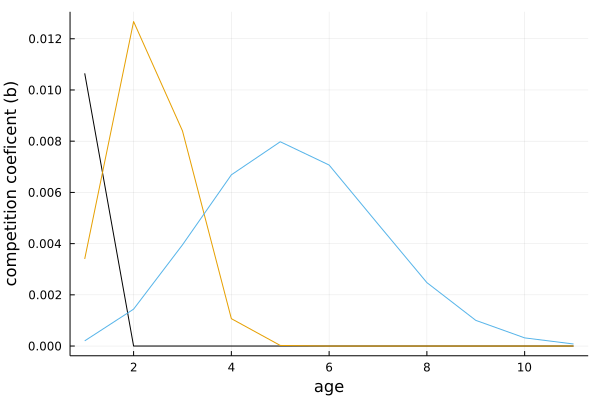

In [53]:
pars.r = 1.0
pop = AgeTraitIntraCohortComp.init(pars)
Plots.plot(vcat([pop.b0],pop.ba[1:10]))
pars.r = 0.001
pop = AgeTraitIntraCohortComp.init(pars)
Plots.plot!(vcat([pop.b0],pop.ba[1:10]))
pars.r = 0.0001
pop = AgeTraitIntraCohortComp.init(pars)
Plots.plot!(vcat([pop.b0],pop.ba[1:10]), legend = :none,
xlab = "age", ylab = "competition coeficent (b)")

## Test simulation

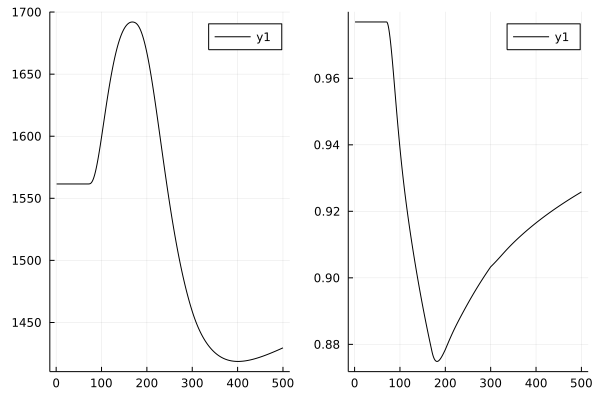

In [41]:
pars.r = 1.0
pop = AgeTraitIntraCohortComp.init(pars)
# test simulation
T = 500
Tstar = 50
duration = 100
p_im = 1.0
RRS = 0.8


Ht = vcat(zeros(Tstar), repeat([pop.Rstar*p_im], duration), zeros(T))
dz = AgeTraitStructuredModels.solve_trait_difference(RRS,pop.s)

Nt = zeros(T)
AHt = zeros(T)
Wt = zeros(T)
for i in 1:T
    im = AgeTraitIntraCohortComp.init_imigrants(pop, Ht[i], dz)
    AgeTraitIntraCohortComp.time_step_DSI!(pop,im)
    Nt[i] = sum(pop.abundanceN)
    Wt[i] = AgeTraitIntraCohortComp.fittness(pop)
end 

p1 = Plots.plot(Nt)
p2 = Plots.plot(Wt)
plot(p1,p2)

## Compare to previous model

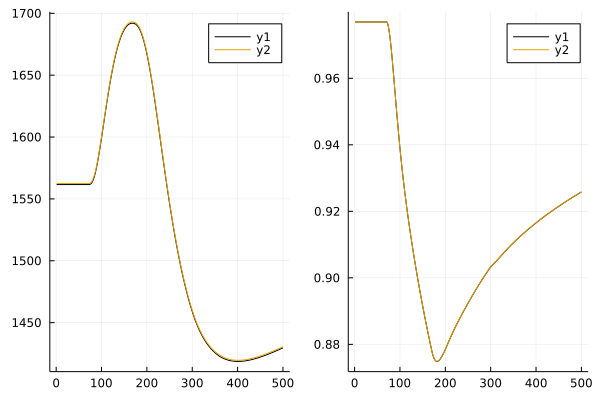

In [24]:
# compare to prior model 
include("AgeStructuredModels.jl")
include("DemographicParameters.jl")
include("AgeTraitStructuredModels.jl")
include("StockRecruitCurves.jl")
using Plots
theme(:wong2)

# initialize demographic model - paramters loaded from DemographicParameters.jl 
# see tests in "TestDemographicParametersparams.ipynb"
mod = DemographicParameters.mod_Smyth_2016



# initialize coupled genetic-demogrpahic model 
pop = AgeTraitStructuredModels.init(mod,Vle, θ, s, min, max, Δz)
StockRecruitCurves.update_BevetonHolt_k!(pop.ageStructure.SRCurve, k)
im = AgeTraitStructuredModels.init_imigrants(pop, 0.0, dz)
print(" ")


theme(:wong2)
AgeTraitStructuredModels.reset!(pop,s)


Wt = zeros(T)
Nt = zeros(T)

for i in 1:T
    im = AgeTraitStructuredModels.init_imigrants(pop, Ht[i], dz)
    AgeTraitStructuredModels.time_step_DSI!(pop, im)
    Nt[i] = sum(pop.abundanceN)
    Wt[i] = AgeTraitStructuredModels.fittness(pop)
end 


Plots.plot!(p1, Nt)
Plots.plot!(p2, Wt)
plot(p1,p2)

## Run simulations with Intra chorot competition

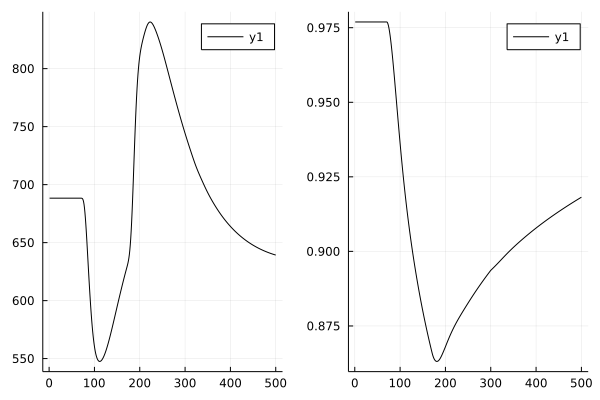

In [25]:
pars.r = 0.00001
pop = AgeTraitIntraCohortComp.init(pars)

# test simulation
T = 500
Tstar = 50
duration = 100
p_im = 1.0
RRS = 0.8


Ht = vcat(zeros(Tstar), repeat([pop.Rstar*p_im], duration), zeros(T))
dz = AgeTraitStructuredModels.solve_trait_difference(RRS,pop.s)

Nt = zeros(T)
AHt = zeros(T)
Wt = zeros(T)
for i in 1:T
    im = AgeTraitIntraCohortComp.init_imigrants(pop, Ht[i], dz)
    AgeTraitIntraCohortComp.time_step_DSI!(pop,im)
    Nt[i] = sum(pop.abundanceN.* (pop.fecundity .> 1)) 
    Wt[i] = AgeTraitIntraCohortComp.fittness(pop)
end 

p1 = Plots.plot(Nt)
p2 = Plots.plot(Wt)
plot(p1,p2)

In [60]:
function paths(pim, RRS, Duration, Policy, pars; maxiter = 5000)
    pop = AgeTraitIntraCohortComp.init(pars)
    dz = AgeTraitStructuredModels.solve_trait_difference(RRS,pop.s)
    Rstar = pars.Rstar
    
    Nls = []
    Hls = []
    Wls = []
    
    W0 = AgeTraitIntraCohortComp.fittness(pop)
    N0 = sum(pop.abundanceN .* (pop.fecundity .> 0))
    
    Wmin = W0 
    Nmin = N0
    
    Wt = AgeTraitIntraCohortComp.fittness(pop)
    Nt = sum(pop.abundanceN .* (pop.fecundity .> 0))
    iter = 0
 
    while ((iter < 5*Duration) | ( ((Wt - Wmin)/(W0 -Wmin) < 0.95 ) | ((Nt - Nmin)/(N0 -Nmin) < 0.95 ) )) & (iter < maxiter)
        iter += 1
       
        if iter <Duration
            if Policy == "fixed"
                Ht = pim*Rstar
            elseif Policy == "linear"
                Ht = pim*pop.abundanceN[1]
            elseif Policy == "squared"
                Ht = pim*(pop.abundanceN[1]/Rstar)^2*Rstar
            elseif Policy == "root"
                Ht = pim*sqrt(pop.abundanceN[1]/Rstar)*Rstar
            end 
            im = AgeTraitIntraCohortComp.init_imigrants(pop,Ht ,dz)
            AgeTraitIntraCohortComp.time_step_DSI!(pop,im)
        else
            im = AgeTraitIntraCohortComp.init_imigrants(pop, 0.0,dz)
            AgeTraitIntraCohortComp.time_step_DSI!(pop,im)
        end 
        if Wmin > Wt
            Wmin = Wt
        end 
        if Nmin > Nt
            Nmin = Nt
        end 
        Wt = AgeTraitIntraCohortComp.fittness(pop)
        Nt = sum(pop.abundanceN.* (pop.fecundity .> 1))
        push!(Nls, Nt) 
        push!(Hls,sum(pop.abundanceH.* (pop.fecundity .> 1)) ) 
        push!(Wls,Wt)
    end 
    return Nls,Hls,Wls
end 

paths (generic function with 1 method)

In [61]:
function sample_pars()
    # set base parameters
    k = rand([1.5,3.0,6.0,9.0]) # 1
    Rstar = 60
    survival = DemographicParameters.Smyth_2016_survival
    survival[end] = 0
    fecundity = DemographicParameters.Smyth_16_F_vec
    Amax = length(survival)
    r = rand([1.0,0.001,0.0001]) # 2
    Wa = DemographicParameters.Smyth_16_WAR.(1:Amax)
    functional_form = rand(["BevertonHolt", "Ricker"]) # 3 #
    Vle = 1.0
    theta = 0.0
    s = rand([0.1,0.05,0.025])  # 4
    
    #RRS
    RRS = rand([0.1,0.3,0.5,0.7,0.9])  # 5
    dz = AgeTraitStructuredModels.solve_trait_difference(RRS,pop.s)
    
    # grid params 
    min = -5.0
    max = dz + 5.0
    dx = 0.1

    pars = AgeTraitIntraCohortComp.params(k,Rstar,survival,fecundity,r,Wa,functional_form,Vle,theta,s,min,max,dx)
    
    pim = rand([0.25,0.5,1.0,2.0])  # 6
    
    Tg = DemographicParameters.Smyth_2016_T1
    Duration = rand([0.5*Tg, 1.0*Tg,2.0*Tg,4.0*Tg])  # 7
    Policy = rand([1,2,3,4])  # 8 #["fixed", "linear", "squared","root"]
    
    return pim, RRS, Duration, Policy, pars
end 

Policy_levels = ["fixed", "linear", "squared","root"]

4-element Vector{String}:
 "fixed"
 "linear"
 "squared"
 "root"

In [62]:
function outcomes(path)
    Nt,Ht,Wt = path
    
    # minimum outcomes
    TWmin = argmin(Wt)
    Wmin = Wt[TWmin]
    TNmin = argmin(Wt)
    Nmin = Nt[TNmin]
    
    # time to recovery 
    Wt_recover = Wt[TWmin:end]
    Wt_recover50 = argmax(Wt_recover[Wt_recover .< (Wmin + 0.5*(Wt[1] - Wmin))])
    Wt_recover90 = argmax(Wt_recover[Wt_recover .< (Wmin + 0.9*(Wt[1] - Wmin))])
    
#     Nt_recover = Nt[TNmin:end]
#     Nt_recover50 = argmax(Nt_recover[Nt_recover .< (Nmin + 0.5*(Nt[1] - Nmin))])
#     Nt_recover90 = argmax(Nt_recover[Nt_recover .< (Nmin + 0.9*(Nt[1] - Nmin))])
    
    return Wmin, Nmin, Wt_recover50, Wt_recover90
end 

outcomes (generic function with 1 method)

In [63]:
pim, RRS, Duration, Policy, pars = sample_pars()

path = paths(pim, RRS, Duration,Policy_levels[Policy], pars)
outcomes(path)

(0.1906955290916957, 200.12711412507954, 983, 3297)

In [64]:
using DelimitedFiles
N_vars = 8 # age structure, order, Duration, selection strength, prop_im, reletive fitness, compensation, removal effort 
N_outcomes = 4 # fitness, natural recrutment, SSB
threads = 6
N_mn = 4000*threads
data = zeros(N_mn, N_vars + N_outcomes)
n = 0
mod_num = 0

n = 0

writedlm( "data/GSA_data.csv",  data, ',')

for n in 1:threads:N_mn

    

    Threads.@threads for j in 0:(threads-1)
        
        pim, RRS, Duration, Policy, pars = sample_pars()
        
        k = pars.k; r = pars.r; s = pars.s; functional_form = pars.functional_form
        
        p = paths(pim, RRS, Duration, Policy_levels[Policy], pars)
        
        Wmin, Nmin, recover50, recover90 = outcomes(p)
        
        data[n+j,:] .= [Wmin, Nmin, recover50, recover90, pim, RRS, Duration,
                        Policy,k,r,s,
                        1.0*(functional_form == "Ricker")] 
    end
    print(n, " ")  
    writedlm( "data/GSA_data.csv",  data, ',')

 
end 

1 7 13 19 25 31 37 43 49 55 61 67 73 79 85 91 97 103 109 115 121 127 133 139 145 151 157 163 169 175 181 187 193 199 205 211 217 223 229 235 241 247 253 259 265 271 277 283 289 295 301 307 313 319 325 331 337 343 349 355 361 367 373 379 385 391 397 403 409 415 421 427 433 439 445 451 457 463 469 475 481 487 493 499 505 511 517 523 529 535 541 547 553 559 565 571 577 583 589 595 601 607 613 619 625 631 637 643 649 655 661 667 673 679 685 691 697 703 709 715 721 727 733 739 745 751 757 763 769 775 781 787 793 799 805 811 817 823 829 835 841 847 853 859 865 871 877 883 889 895 901 907 913 919 925 931 937 943 949 955 961 967 973 979 985 991 997 1003 1009 1015 1021 1027 1033 1039 1045 1051 1057 1063 1069 1075 1081 1087 1093 1099 1105 1111 1117 1123 1129 1135 1141 1147 1153 1159 1165 1171 1177 1183 1189 1195 1201 1207 1213 1219 1225 1231 1237 1243 1249 1255 1261 1267 1273 1279 1285 1291 1297 1303 1309 1315 1321 1327 1333 1339 1345 1351 1357 1363 1369 1375 1381 1387 1393 1399 1405 1411 1417 1

12×12 Matrix{Float64}:
 0.83797   620.416   66.0   346.0  0.25  0.1  …  0.0  9.0  1.0    0.025  0.0
 0.800896  671.021   87.0   710.0  0.5   0.3     0.0  1.5  0.01   0.05   0.0
 0.976854  586.622  112.0  1534.0  0.25  0.9     0.0  9.0  1.0    0.025  1.0
 0.701664  487.704  196.0   769.0  0.5   0.5     0.0  3.0  1.0    0.1    1.0
 0.757323  271.204  402.0  1497.0  1.0   0.7     1.0  9.0  0.01   0.05   1.0
 0.918111  645.247  138.0  1069.0  0.25  0.7  …  0.0  6.0  0.001  0.05   0.0
 0.543086  588.729   84.0   411.0  1.0   0.1     1.0  1.5  0.01   0.1    1.0
 0.850584  617.039  195.0  1224.0  1.0   0.7     1.0  3.0  0.001  0.05   0.0
 0.86044   622.394   52.0   176.0  0.25  0.1     1.0  6.0  0.001  0.1    1.0
 0.767405  432.47   230.0   807.0  0.5   0.7     1.0  9.0  1.0    0.1    1.0
 0.900487  661.188   58.0   212.0  0.25  0.3  …  1.0  1.5  1.0    0.1    0.0
 0.815391  609.979   63.0   273.0  0.25  0.1     1.0  9.0  0.001  0.05   0.0